In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [2]:
current_working_directory = os.getcwd()
path = os.path.dirname(current_working_directory)
year = "2019"
result_path = f"{path}/CW/data/Results/"

In [3]:
def impact_resultant_prices(model, trades, prices, decay_factor, estimated_lambda, sigma, ADV, back=False):
    trades_copy = trades.copy()
    if back:
        trades_copy *= -1

    if model == "OW":
        trades_copy = trades_copy
    elif model == "Bouchaud":
        trades_copy = np.sign(trades_copy) * np.sqrt(np.abs(trades_copy))
    elif model == "Reduced":
        trades_copy = np.abs(trades_copy)
    else:
        raise ValueError("Unsupported model")

    # Adjust trades for decay
    trades_copy[1:] /= (1 - decay_factor)

    # Scale trades by price volatility and ADV
    if model == "OW":
        trades_copy *= sigma * estimated_lambda/ ADV
    elif model == "Bouchaud":
        trades_copy *= sigma * estimated_lambda/ np.sqrt(ADV)
    elif model == "Reduced":
        v_t = trades_copy.ewm(alpha=1 - decay_factor, adjust=False).mean()
        trades_copy *= sigma * estimated_lambda/ np.sqrt(ADV * v_t + 1e-10)  # use 1e-10 to avoid division by zero

    Impact = trades_copy.ewm(alpha=1-decay_factor, adjust=False).mean()

    Returns = prices / prices.iloc[0] - 1
    Returns += Impact
    # Return resultant prices
    return prices.iloc[0] * (Returns + 1)

In [4]:
def compute_regression_result(daily_stock_reg_info_df, in_sample_month):
    daily_stock_reg_info_df['date'] = pd.to_datetime(daily_stock_reg_info_df['date'])
    in_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month]
    out_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month + 1]

    # for each stock, calculate the sum of x, y, xy, x^2, y^2, and count
    in_sample_result_df = in_sample_df.groupby("stock")[["xy", "x2", "y2", "x", "y", "count"]].sum()
    out_sample_result_df = out_sample_df.groupby("stock")[["xy", "x2", "y2", "x", "y", "count"]].sum()

    in_sample_result_df.columns = "IS_" + in_sample_result_df.columns
    out_sample_result_df.columns = "OOS_" + out_sample_result_df.columns

    result_df = pd.merge(in_sample_result_df, out_sample_result_df, left_index=True, right_index=True, how="inner")

    Cov_x_y = result_df["IS_xy"] - result_df["IS_x"] * result_df["IS_y"] / result_df["IS_count"]
    Var_x = result_df["IS_x2"] - result_df["IS_x"] ** 2 / result_df["IS_count"]
    result_df["lambda_estimate"] = Cov_x_y / Var_x
    result_df["epsilon_estimate"] = result_df["IS_y"] / result_df["IS_count"] - result_df["lambda_estimate"] * result_df["IS_x"] / result_df["IS_count"]
    result_df["IS_SST"] = result_df["IS_y2"] - result_df["IS_y"] ** 2 / result_df["IS_count"]
    result_df["IS_RSS"] = (result_df["IS_count"] * result_df["epsilon_estimate"] ** 2 +
                           2 * result_df["epsilon_estimate"] * result_df["lambda_estimate"] * result_df["IS_x"] -
                           2 * result_df["epsilon_estimate"] * result_df["IS_y"] +
                           result_df["lambda_estimate"] ** 2 * result_df["IS_x2"] -
                           2 * result_df["lambda_estimate"] * result_df["IS_xy"] +
                           result_df["IS_y2"])
    result_df["IS_R2"] = 1 - result_df["IS_RSS"] / result_df["IS_SST"]

    result_df["OOS_SST"] = result_df["OOS_y2"] - result_df["OOS_y"] ** 2 / result_df["OOS_count"]
    result_df["OOS_RSS"] = (result_df["OOS_count"] * result_df["epsilon_estimate"] ** 2 +
                            2 * result_df["epsilon_estimate"] * result_df["lambda_estimate"] * result_df["OOS_x"] -
                            2 * result_df["epsilon_estimate"] * result_df["OOS_y"] +
                            result_df["lambda_estimate"] ** 2 * result_df["OOS_x2"] -
                            2 * result_df["lambda_estimate"] * result_df["OOS_xy"] +
                            result_df["OOS_y2"])
    result_df["OOS_R2"] = 1 - result_df["OOS_RSS"] / result_df["OOS_SST"]

    return result_df

In [5]:
num_days_precompute = 20
filename = f"inter_results_stock_info_df_{year}all.csv"
stock_info_df = pd.read_csv(result_path+filename)
stacked_info = stock_info_df.pivot(index="date", columns="stock", values=["px_vol", "volume"]).rolling(num_days_precompute).mean().shift(1)
scaling_df = pd.DataFrame({
    "px_vol": stacked_info["px_vol"].unstack(),
    "volume": stacked_info["volume"].unstack(),
}).reset_index()

asset = "AAPL"
dates = "2019-03-14"

ssdf = scaling_df[(scaling_df["stock"] == asset) & (scaling_df["date"] == dates)]
price_vol = ssdf["px_vol"]
ADV = ssdf["volume"]
decay = np.exp(-np.log(2) / 3600 * 10)

month = dates.split("-")[1]
in_sample = int(month) - 1

filename = f"inter_results_px_df_{2019}{month}.csv"
px_df = pd.read_csv(result_path+filename).set_index(["stock","date"])
filename = f"inter_results_trade_volume_df_{2019}{month}.csv"
volumes = pd.read_csv(result_path+filename).set_index(["stock","date"])
prices = px_df.loc[(asset,dates)]
trades = volumes.loc[(asset,dates)]

In [6]:
filename = f"OW_reg_info_{year}_horizon{1}_beta{60}mins.csv"
test_OW = pd.read_csv(result_path+filename)
res_ow = compute_regression_result(test_OW, in_sample)
res_ow = res_ow.loc[asset]

In [7]:
def synthetic_alpha_generator(rho: float, prices: pd.DataFrame, horizon: int):
    """
    rho: correlation
    horizon: number of 10 seconds
    prices: impact-adjusted prices
    """
    x = rho ** 2
    returns = prices.pct_change(horizon)
    var = returns.var()
    p_minus2 = 1/(prices**2)
    p_minus_mean = p_minus2.mean()
    h = horizon
    y = rho * np.sqrt(1-rho**2)*np.sqrt(var/(h*p_minus_mean))
    normal = rng.normal(loc = 0, scale = h, size = prices.shape)
    res = x * returns + y * normal / prices
    
    return res.fillna(0),returns

In [8]:
def synthetic_alpha(rho, asset, dates):
    """
    rho: correlation
    asset: name of stock
    dates: date of trade
    """
    ssdf = scaling_df[(scaling_df["stock"] == asset) & (scaling_df["date"] == dates)]
    price_vol = ssdf["px_vol"]
    ADV = ssdf["volume"]
    decay = np.exp(-np.log(2) / 3600 * 10)

    month = dates.split("-")[1]
    in_sample = int(month) - 1

    filename = f"inter_results_px_df_{2019}{month}.csv"
    px_df = pd.read_csv(result_path+filename).set_index(["stock","date"])
    filename = f"inter_results_trade_volume_df_{2019}{month}.csv"
    volumes = pd.read_csv(result_path+filename).set_index(["stock","date"])
    prices = px_df.loc[(asset,dates)]
    trades = volumes.loc[(asset,dates)]
    filename = f"OW_reg_info_{year}_horizon{1}_beta{60}mins.csv"
    test_OW = pd.read_csv(result_path+filename)
    res_ow = compute_regression_result(test_OW, in_sample)
    res_ow = res_ow.loc[asset]

    S = impact_resultant_prices("OW", trades, prices, decay, res_ow["lambda_estimate"], price_vol.values, ADV.values)
    alpha,returns = synthetic_alpha_generator(rho, S, 1)

    return alpha,returns,price_vol,ADV, res_ow["lambda_estimate"],S

In [9]:
def smooth_alpha(alpha, time_unit = 10):
    smoothed = alpha.ewm(halflife=200).mean()
    deriv_1 = smoothed.diff(1).shift(-1).fillna(0) / time_unit
    deriv_2 = smoothed.diff(1).diff(1).shift(-1).fillna(0) / (time_unit ** 2)
    return smoothed[200:], deriv_1[200:], deriv_2[200:]

In [10]:
def optimal_trade(alpha, half_life, px_vol, ADV, impact_coef, time_unit = 10, model = "OW"):
    beta = np.log(2)/half_life
    decay_factor = np.exp(-beta * time_unit)
    if model == "Reduced":
        pass
    elif model == "OW":
        smoothed, deriv_1, deriv_2 = smooth_alpha(alpha)
        optimal_impact = 0.5 * (smoothed - deriv_1 / beta)
        optimal_impact.iloc[-1] = smoothed.iloc[-1]
        optimal_trades = beta * (smoothed - deriv_2/ (beta ** 2 )) / (px_vol.values / ADV.values * impact_coef) / 2 * time_unit
        optimal_trades.iloc[0] = optimal_impact.iloc[0] / (px_vol / ADV * impact_coef) # I_0^* / lambda
        optimal_trades.iloc[-1] += (smoothed.iloc[-1] - optimal_impact.iloc[-2] * decay_factor) / (px_vol.values / ADV.values * impact_coef)
        
        pct_synthetic_alpha_optimal_trades = optimal_trades / ADV.values
        total_trade_sizes = abs(pct_synthetic_alpha_optimal_trades).sum() # if df then axis = 1
        
        return optimal_trades,optimal_impact,pct_synthetic_alpha_optimal_trades, total_trade_sizes

In [11]:
num_days_precompute = 20
filename = f"inter_results_stock_info_df_{year}all.csv"
stock_info_df = pd.read_csv(result_path+filename)
stacked_info = stock_info_df.pivot(index="date", columns="stock", values=["px_vol", "volume"]).rolling(num_days_precompute).mean().shift(1)
scaling_df = pd.DataFrame({
    "px_vol": stacked_info["px_vol"].unstack(),
    "volume": stacked_info["volume"].unstack(),
}).reset_index()



In [12]:
asset = "AAPL"
date_list = ['2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19',
    '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-25',
    '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29',
    '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04',
    '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10',
    '2019-04-11', '2019-04-12', '2019-04-15', '2019-04-16',
    '2019-04-17', '2019-04-18']
rho = 0.3
def func():
    l=[]
    for dates in date_list:
        alpha,returns,price_vol, ADV, res_ow_beta,S = synthetic_alpha(rho, asset, dates)
        alpha = alpha.cumsum()
        returns = returns.cumsum()
        smoothed, deriv_1, deriv_2 = smooth_alpha(alpha)
        opt_trades, opt_impact, volume_pct,sizes = optimal_trade(alpha, 3600, price_vol, ADV, res_ow_beta, time_unit = 10, model = "OW")
        l.append((opt_trades, opt_impact, volume_pct, sizes,S,smoothed,returns))
    return l


In [13]:
l= func()

C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21152\1301893758.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -4748496.00680968  -3336008.19747074   -763169.71075067 ...
   4737578.72893109 -36989297.06377441         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay_factor)
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21152\1301893758.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-5722733.08987967   493876.85641222   268772.98396328 ...
  4301407.48416283 -3378637.56823474        0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay_factor)
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21152\1301893758.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated a

In [14]:
corr = [(l[i][5]).corr(l[i][6]) for i in range(len(l))]
print(corr)

[-0.05887962236572673, -0.18367506571008246, 0.6302293999665197, 0.6916296340184462, 0.8133208894480639, 0.5423699761837039, -0.8365311647635121, 0.7701527897615158, 0.9447647577357683, 0.13949565498000757, 0.03876090597617575, 0.4164341253001804, 0.44177325437319664, 0.5815622769798364, 0.6482144758226664, -0.27990640241003284, -0.4202802151924957, 0.5686498166943401, 0.2019246464186234, 0.7185645222363857, 0.8067166645872147, 0.8439862037573358, -0.1674455766995543, -0.04114029004062497, 0.2134623780511388, 0.37165625211290604]


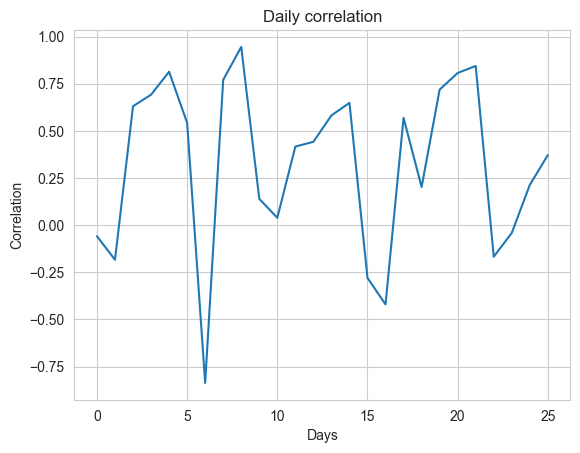

In [15]:
plt.plot(corr)
plt.title('Daily correlation')
plt.xlabel('Days')  
plt.ylabel('Correlation')  
plt.show()

In [16]:
def calculate_pnl(trades, prices,optimal_impact):
    cum_trades = trades.cumsum()
    gain = prices.iloc[-1]*cum_trades.iloc[-1] - prices * trades.shift(-1)
    impact_cost = -optimal_impact * trades.shift(-1)
    pnl = (gain + impact_cost).fillna(0).cumsum()
    notional = (trades.abs() * prices).sum()
    pnl =  pnl/notional
    return pnl


In [17]:
pnls = []
for item in l:
    temp = calculate_pnl(item[0],item[4],item[1])[-1]
    print(temp)
    pnls.append(temp)
print(pnls)    

-38.88543364540058
-44.665298271903296
17.03212287200562
-140.36827622349526
-0.13066758374976548
78.23824033896435
162.29711246300414
20.464560299046198
-143.99529152915986
92.9154841733295
-18.22807007697463
55.97774200328334
4.047537319285006
158.7127994958017
-58.60849265681558
-79.88839989238325
-16.471358590752544
176.90105912404354
7.0552781561363105
39.718619308600246
-257.53488399973867
-5.552333703037546
0.22438298696229828
13.980068069236873
64.76683420263859
-83.21268301025682
[-38.88543364540058, -44.665298271903296, 17.03212287200562, -140.36827622349526, -0.13066758374976548, 78.23824033896435, 162.29711246300414, 20.464560299046198, -143.99529152915986, 92.9154841733295, -18.22807007697463, 55.97774200328334, 4.047537319285006, 158.7127994958017, -58.60849265681558, -79.88839989238325, -16.471358590752544, 176.90105912404354, 7.0552781561363105, 39.718619308600246, -257.53488399973867, -5.552333703037546, 0.22438298696229828, 13.980068069236873, 64.76683420263859, -83.2

C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21152\267309378.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = calculate_pnl(item[0],item[4],item[1])[-1]
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21152\267309378.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = calculate_pnl(item[0],item[4],item[1])[-1]
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21152\267309378.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

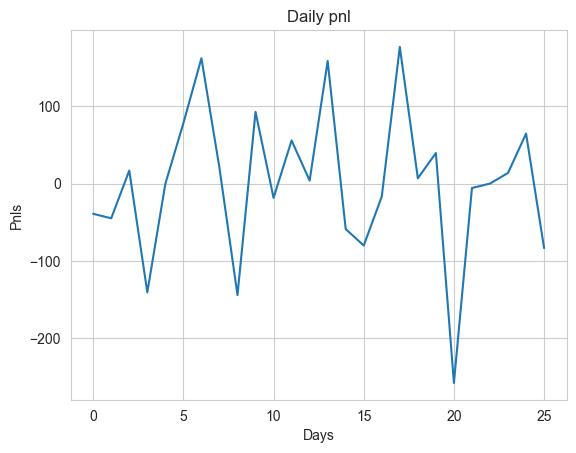

In [18]:
plt.plot(pnls)
plt.title('Daily pnl')
plt.xlabel('Days')  
plt.ylabel('Pnls')  
plt.show()

In [19]:
sharpe = []
for item in l:
    temp = calculate_pnl(item[0],item[4],item[1])
    temp = np.array(temp)
    index1 = np.nonzero(temp)
    temp = temp[index1]
    ret = (temp[1:]-temp[:-1])/temp[:-1]
    ret = np.array(ret)
    average_ret = np.nanmean(ret)
    excess_return = average_ret - 0.01/252
    stdd = np.nanstd(ret)
    
    sharpe_ratio = excess_return/stdd
    sharpe.append(sharpe_ratio)
print(sharpe)
    

[0.12686718211612172, 0.1417590177964215, 0.1151207913877654, 0.13800592512468576, 0.0006333675825920513, 0.13641554799029434, 0.1392352293769515, 0.13412390352333298, 0.13964684351170517, 0.13994042112718005, 0.12167145026448233, 0.14512166634582982, 0.10292547682123217, 0.1369512949953124, 0.13685808112786443, 0.13760454618679877, 0.14012095474138614, 0.13783373408567345, 0.15835389267287833, 0.13722091426773658, 0.13764877855253238, 0.17047583054326437, 0.02258536282126423, 0.15713430662267133, 0.13521892376708247, 0.13907747046651067]


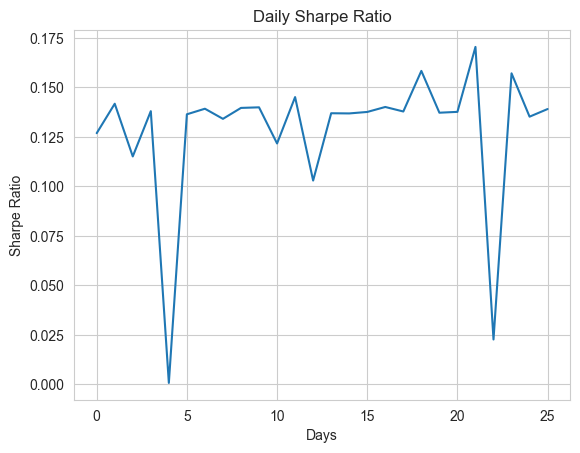

In [20]:
plt.plot(sharpe)
plt.title('Daily Sharpe Ratio')
plt.xlabel('Days') 
plt.ylabel('Sharpe Ratio') 
plt.show()

In [21]:
transaction_cost = []
for i in range(len(l)):
    temp = (l[i][4])*(l[i][0]).abs()*0.002+(0.5+0.05)*(l[i][0]).abs()
    transaction_cost.append(temp.mean())
print(transaction_cost)

[1019.2818011894003, 1132.004876212391, 982.9884915640325, 1297.459529574953, 1305.6783195408213, 1575.3025440629046, 1858.2135606993777, 2043.8973166192918, 1963.1130100882333, 1622.8939730063623, 1179.5183337693416, 1232.863809777632, 1397.013279342445, 1163.6380295746076, 1238.9976553103998, 1111.6868180499855, 981.8791940057548, 2098.8438007799086, 1479.398589202274, 1285.0618253626567, 1173.3053942936017, 1383.3333609121587, 953.6048838960419, 1355.1045416657967, 1373.2708145883605, 1063.7063268758304]


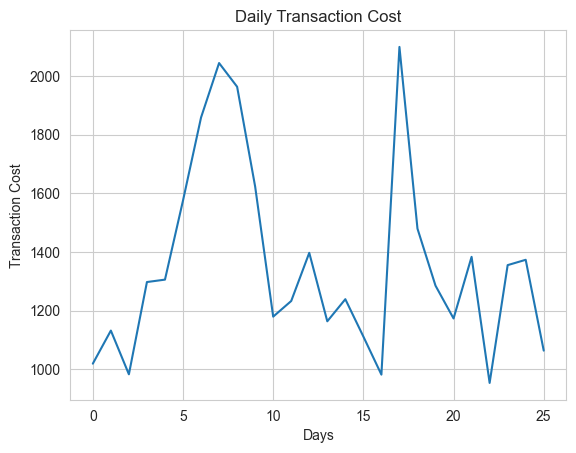

In [22]:
plt.plot(transaction_cost)
plt.title('Daily Transaction Cost')
plt.xlabel('Days')  # Label for the X-axis
plt.ylabel('Transaction Cost')  # Label for the Y-axis
plt.show()

In [23]:
mdd = []
for item in l:
    temp = calculate_pnl(item[0],item[4],item[1])
    temp = np.array(temp)
    peaks = np.maximum.accumulate(temp)
    dds = np.divide(temp - peaks, np.where(peaks == 0, 1, peaks))
    mdds = dds.min() 
    mdd.append(mdds)    
    
print(mdd)

[-38.88543364540058, -44.665298271903296, 0.0, -140.36827622349526, -13.221266683143325, 0.0, 0.0, -0.0003955133186286292, -143.99529152915986, 0.0, -18.22807007697463, 0.0, -0.1321721622289017, 0.0, -58.60849265681558, -79.88839989238325, -16.471358590752544, 0.0, -0.0009500728117046013, 0.0, -257.53488399973867, -5.552333703037546, -1.676586488411492, 0.0, 0.0, -83.21268301025682]


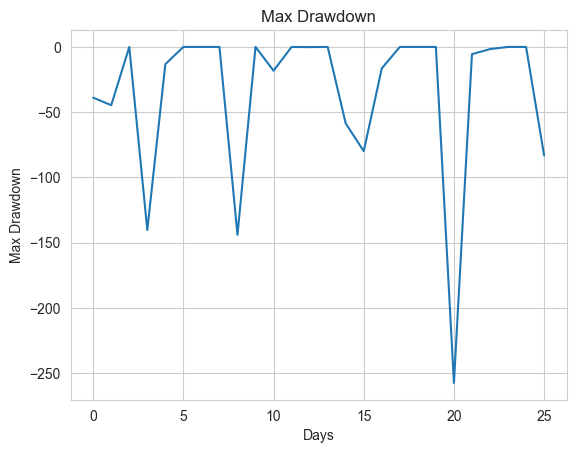

In [24]:
plt.plot(mdd)
plt.title('Max Drawdown')
plt.xlabel('Days')  # Label for the X-axis
plt.ylabel('Max Drawdown')  # Label for the Y-axis
plt.show()